In [1]:
from ndreg import *
import matplotlib
import ndio.remote.neurodata as neurodata

In [2]:
import SimpleITK as sitk

In [3]:
raw_s275 = sitk.ReadImage('/home/s275.nii')

In [4]:
ara3_atlas = sitk.ReadImage('/home/ara3.nii')

In [5]:
ara3_annotations = sitk.ReadImage('/home/ara3_annotation.nii')

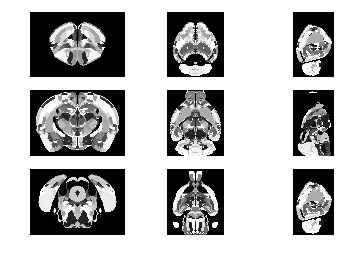

In [6]:
imgShow(ara3_annotations, vmax=1000)

In [7]:
inImg = raw_s275;
refAnnoImg = ara3_annotations;
refImg = ara3_atlas;

In [8]:
refThreshold = imgPercentile(refImg, 0.99)

In [9]:
inImg.SetSpacing(np.array(inImg.GetSpacing())*1000) ###

In [10]:
inThreshold = imgPercentile(inImg, 0.95)

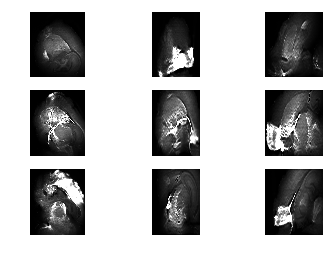

In [11]:
imgShow(inImg, vmax=inThreshold)

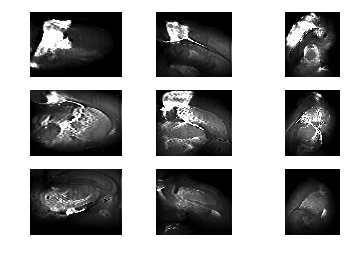

In [12]:
inOrient = "IAL"
refOrient = "RSA"
inImg = imgReorient(inImg, inOrient, refOrient)
imgShow(inImg, vmax=inThreshold)

In [13]:
inImgSize_reorient = inImg.GetSize()
inImgSpacing_reorient= inImg.GetSpacing()

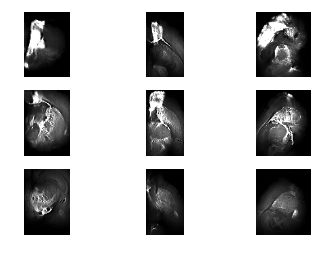

In [14]:
spacing = [0.1,0.1, 0.1]
inImg_ds = imgResample(inImg, spacing)
imgShow(inImg_ds, vmax=inThreshold)

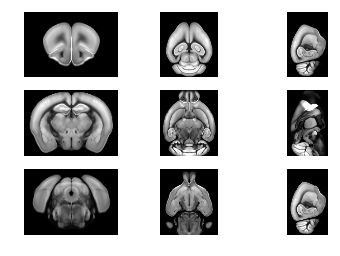

In [15]:
refImg_ds = imgResample(refImg, spacing)
imgShow(refImg_ds, vmax=refThreshold)

In [16]:
#SKIPPED: imgWrite(inImg_ds,"/home/s275_ch0_rsa_100um.img")

In [17]:
roiStart = [5.4, 1.2, 2.1]
roiSize = [4.5,6.5,7.5]

In [18]:
roiStartVoxel = (roiStart / np.array(spacing)).astype('uint16').tolist()
print(roiStartVoxel)
roiSizeVoxel = (roiSize / np.array(spacing)).astype('uint16').tolist()
print(roiSizeVoxel)

[54, 11, 21]
[45, 65, 75]


In [19]:
roiImg = sitk.Image(roiSizeVoxel,sitk.sitkUInt8)
roiImg += 255

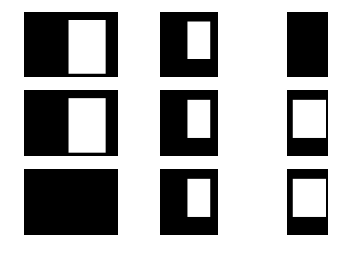

In [20]:
emptyImg = sitk.Image(refImg_ds.GetSize(),sitk.sitkUInt8) # Create an empty image
emptyImg.CopyInformation(refImg_ds) # Copy spacing, origin and direction from reference image
refMask = sitk.Paste(emptyImg, roiImg, roiSizeVoxel, [0,0,0], roiStartVoxel)
imgShow(refMask, vmax=255)

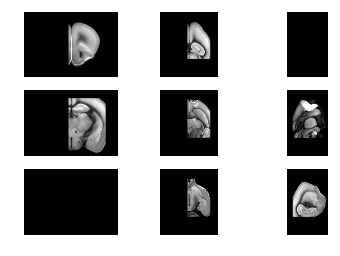

In [21]:
refImg_ds = sitk.Mask(refImg_ds, refMask)
imgShow(refImg_ds, vmax=refThreshold)

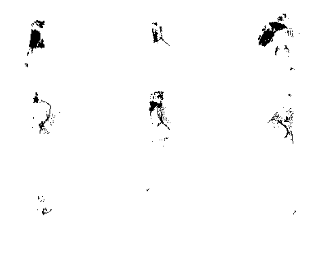

In [22]:
threshold = imgPercentile(inImg_ds,0.95)
inMask_ds = sitk.BinaryThreshold(inImg_ds, 0, threshold, 255, 0)
imgShow(inMask_ds, vmax=255)

[1.2, 0, 0, 0, 1.2, 0, 0, 0, 1, -5.4, -1.2, -2.1]


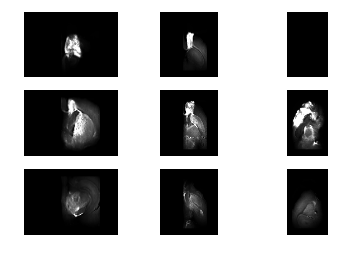

In [23]:
translation = -np.array(roiStart)
inAffine = [1.2,0,0,0,1.2,0,0,0,1]+translation.tolist()
print(inAffine)
imgShow(imgApplyAffine(inImg_ds, inAffine, size=refImg_ds.GetSize()),vmax = inThreshold)

In [24]:
print inImg_ds.GetSize()

(56, 81, 98)


In [25]:
print refImg_ds.GetSize()

(114, 80, 132)


In [26]:
affine = imgAffineComposite(inImg_ds, refImg_ds, inMask=inMask_ds, iterations=100, useMI=True, verbose=True, inAffine=inAffine)

Step translation:
0.	 -0.137237120004
1.	 -0.149209257326
2.	 -0.159805269893
3.	 -0.173666440959
4.	 -0.188887054949
5.	 -0.199909760547
6.	 -0.216258552178
7.	 -0.230184599294
8.	 -0.238259683764
9.	 -0.254724267854
10.	 -0.27027243675
11.	 -0.2802624687
12.	 -0.291127956033
13.	 -0.300925239601
14.	 -0.307259371684
15.	 -0.311580177099
16.	 -0.31909009116
17.	 -0.317394573312
18.	 -0.317413134829
19.	 -0.317540650308
20.	 -0.317548499204
21.	 -0.320206206282
22.	 -0.320227604808
23.	 -0.317571836708
24.	 -0.317574690201
Step scale:
0.	 -0.315901305709
1.	 -0.30150329199
2.	 -0.338886179807
3.	 -0.316760885576
4.	 -0.33585607228
5.	 -0.340090887355
6.	 -0.335649831653
7.	 -0.336463120768
8.	 -0.336465307209
Step rigid:
0.	 -0.335481265548
1.	 -0.240324823519
2.	 -0.327337848642
3.	 -0.335090725689
4.	 -0.34297849163
5.	 -0.333775842663
6.	 -0.338548721913
7.	 -0.341739336367
8.	 -0.340934057679
Step affine:
0.	 -0.349482981238
1.	 -0.300005780089
2.	 -0.362692778658
3.	 -0.3748389028

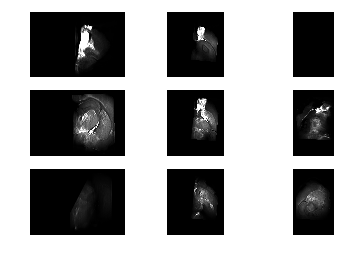

In [29]:
inImg_affine = imgApplyAffine(inImg, affine, size=refImg.GetSize(), spacing=refImg.GetSpacing())
inImg_ds = imgResample(inImg_affine, spacing=spacing, size=refImg_ds.GetSize())
imgShow(inImg_affine, vmax = inThreshold)

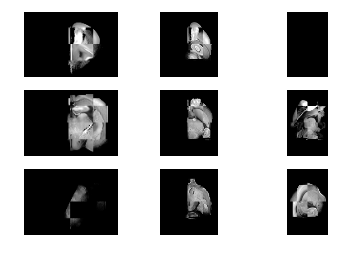

In [30]:
inImg_ds = imgResample(inImg_affine, spacing=spacing, size=refImg_ds.GetSize())
imgShow(imgChecker(inImg_ds, refImg_ds), vmax=refThreshold)

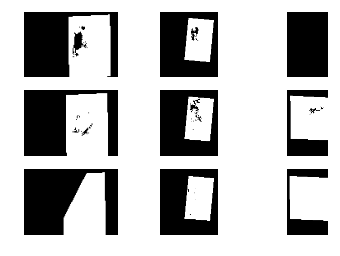

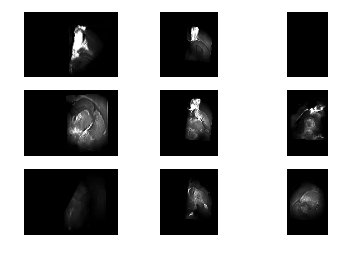

In [ ]:
inMask_ds = imgApplyAffine(inMask_ds, affine, useNearest=True, size=refImg_ds.GetSize())
imgShow(inMask_ds, vmax=255)
imgShow(inImg_ds, vmax=inThreshold)

In [ ]:
inImg_ds = imgResample(inImg_affine, spacing=spacing, size=refImg_ds.GetSize())
(field, invField) = imgMetamorphosisComposite(inImg_ds, refImg_ds, inMask=inMask_ds, alphaList=[0.1, 0.05,0.02],
                                              scaleList = [1.0, 1.0,1.0], useMI=True, iterations=100, verbose=True)


Step 0: alpha=0.1, beta=0.05, scale=1.0


In [ ]:
inImg_lddmm = imgApplyField(inImg_affine, field, size=refImg.GetSize())
imgShow(inImg_lddmm, vmax=inThreshold)